In [51]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import torch

from nilearn.image import load_img
from nilearn.image.image import mean_img
from nilearn.plotting.img_plotting import plot_roi

from dataloader import HaxbyDataset, prepare_sub_data, load_mask_from_nifti
from models import ExtractSegments, ccw, Encoder, get_results_for_sub, train_lstm_model, train_attention_model
from utils import show_scan_slices, save_scan_slices
from ablation import get_ablation_1_results_for_sub, get_ablation_2_results_for_sub

In [42]:
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [Haxby datset](http://www.pymvpa.org/datadb/haxby2001.html)

During the experiment, the subjects were shown various images. Image categories are represented in labels, namely, each label corresponds to a certain category of images. For example, if images of various objects were used in the experiment, the labels may indicate certain objects.

Classes:
- bottle
- cat
- chair
- face
- house
- scissors
- scrambled pix
- shoe

There are also rest periods indicated by rest.

In [43]:
dataset = HaxbyDataset()

# Paths to dataset files
data_files = dataset.data_files

# Drawing examples of stimuli
# dataset.plot_stimuli()

We will get the data of the first test subject

In [45]:
fmris, labels = dataset.get_sub_data(1)

In [ ]:
fmris.shape

(40, 64, 64, 1452)

#### Activity masks

In [ ]:
vt_mask_filename = load_img(data_files.mask_vt[0])
func_filename = data_files.func[0]
mean_haxby = mean_img(func_filename)
vt_mask = vt_mask_filename.get_fdata().shape

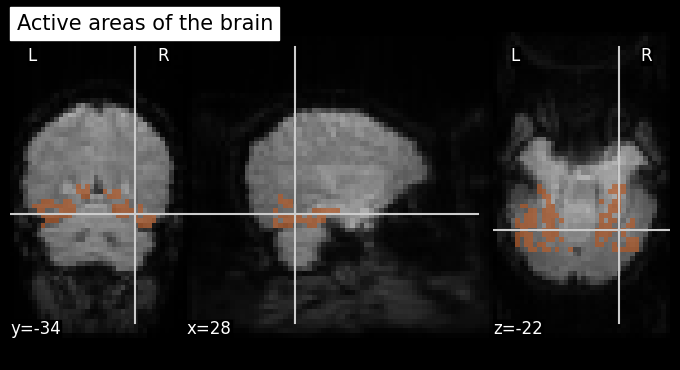

In [ ]:
plot_roi(vt_mask_filename, bg_img=mean_haxby, title = 'Active areas of the brain', draw_cross=True, cmap='Paired')
plt.show()

Getting tensor of the mask

In [ ]:
vt_mask_filename = load_img(data_files.mask_vt[0])
vt_mask_tensor = load_mask_from_nifti(vt_mask_filename)

In [ ]:
len(vt_mask_tensor[vt_mask_tensor==1])

577

### Data preparation
The data of the first subject is stored in fmris, labels variables, we divide the sequence into time series by classes.
Let's encode the classes as follows: 
- rest: 0
- bottle: 1
- cat: 2
- chair: 3
- face: 4
- house: 5
- scissors: 6
- scrambledpix: 7
- shoe: 8

Also, let's pay attention to the structure of the data, before the stimulus is shown and after the stimulus is shown, there are about 5 moments of rest time. The stimulus itself is demonstrated at exactly 9 points in time, so let's fix $\tau = 19$.

$\mu = 2.5$ Hz

In [ ]:
fmris_transposed, stimuli, mask = prepare_sub_data(1)

In [ ]:
# Segmentation of the time series by stimuli classes
X, s, y = ExtractSegments(fmris_transposed, stimuli, tau=19)
y=y-1

In total, 96 fMRI time series of length 19 were obtained, each class has 12 rows.

### Testing the BAD Algorithm

#### Calculating metrics for predicting activity masks

In [ ]:
def calculate_precision(predicted_mask, target_mask):
    intersection = np.logical_and(predicted_mask, target_mask)
    precision = np.sum(intersection) / np.sum(predicted_mask)
    return precision

def calculate_recall(predicted_mask, target_mask):
    intersection = np.logical_and(predicted_mask, target_mask)
    recall = np.sum(intersection) / np.sum(target_mask)
    return recall

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [47]:
fmris_transposed, stimuli, mask = prepare_sub_data(1)
predicted_mask, p_values = ccw(fmris_transposed, stimuli, mu=2.5, k_s=4, Delta_t=0, h=10)
p_values_mask = (np.array(p_values < 0.05)).astype(int)

In [50]:
iou_value = calculate_iou(vt_mask_tensor, predicted_mask)
print("IoU:", iou_value)

precision = calculate_precision(predicted_mask, vt_mask_tensor)
print("precision:", precision)

recall = calculate_recall(predicted_mask, vt_mask_tensor)
print("recall:", recall)

recall_statistic = calculate_recall(predicted_mask, p_values_mask)
print("recall of statistically significant:", recall_statistic)

precision_statistic = calculate_precision(predicted_mask, p_values_mask)
print("precision of statistically significant:", precision_statistic)

IoU: 0.1384471468662301
precision: 0.23125
recall: 0.2564991334488735
recall of statistically significant: 0.1388888888888889
precision of statistically significant: 1.0


#### An example of applying the method over the entire time series of the subject:

In [ ]:
# visualization func
def plot_ccw_results(X, s, mu, k_s, Delta_t, h, masked_brain=False):
    M, p_values = ccw(X, s, mu, k_s, Delta_t, h, masked_brain)
    show_scan_slices(X[0], [28, 20, 24], M, title='Mask by top h correlations')
    show_scan_slices(X[0], [28, 20, 24], p_values<0.05, title='Mask obtained from rejected hypotheses')
    print(f'The number of areas obtained by statistical analysis: {np.sum(p_values<0.05)}')

In [ ]:
fmris_transposed, stimuli, mask = prepare_sub_data(1)
X, s, y = ExtractSegments(fmris_transposed, stimuli, tau=19)
y=y-1

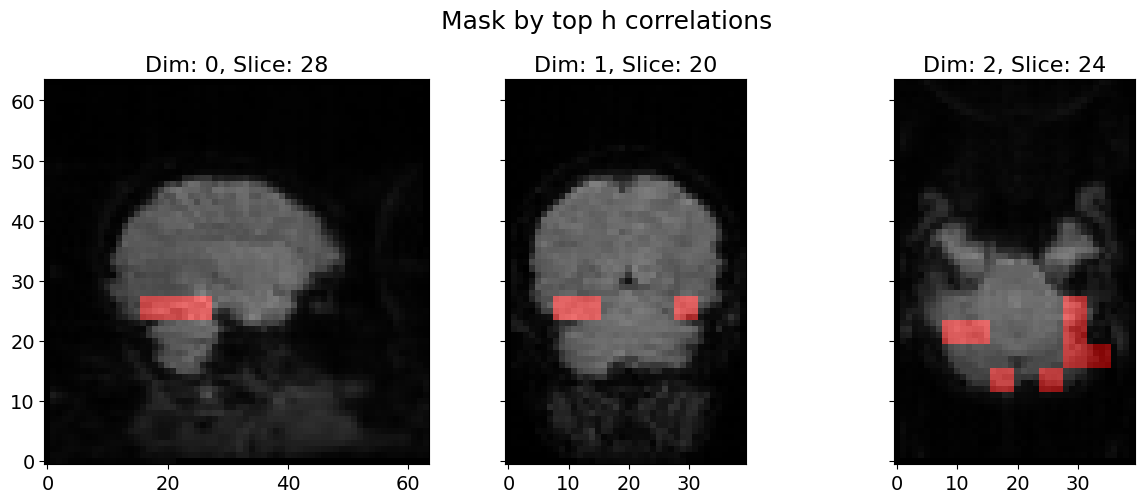

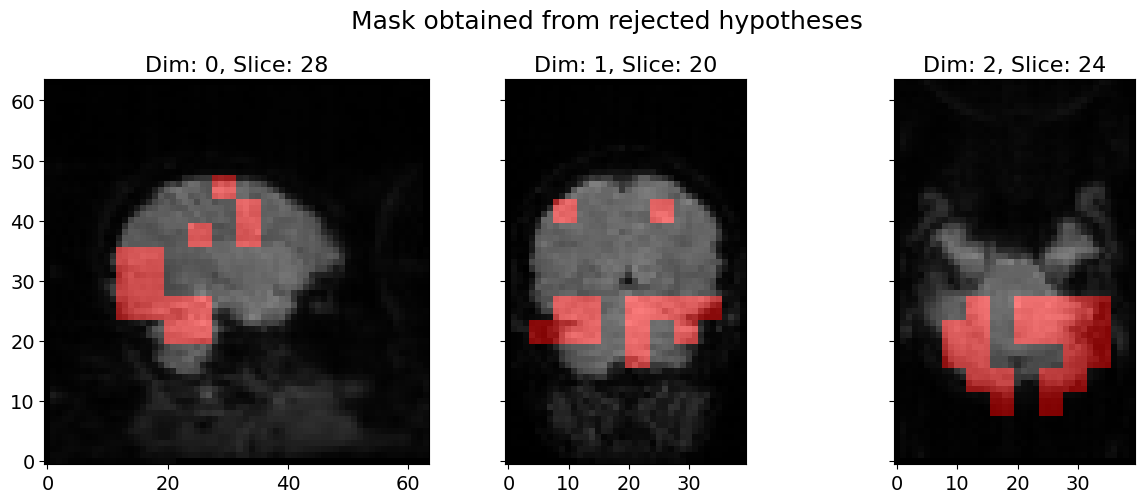

The number of areas obtained by statistical analysis: 5376


In [ ]:
bin_stimuli = stimuli.copy()
bin_stimuli[bin_stimuli!=0]=1

plot_ccw_results(X=fmris_transposed, s=bin_stimuli, mu=2.5, k_s=4, Delta_t=0, h=10, masked_brain=False)

#### We apply the method on a small time series of fMRI, which corresponds to a certain stimulus:

##### 1) Cat

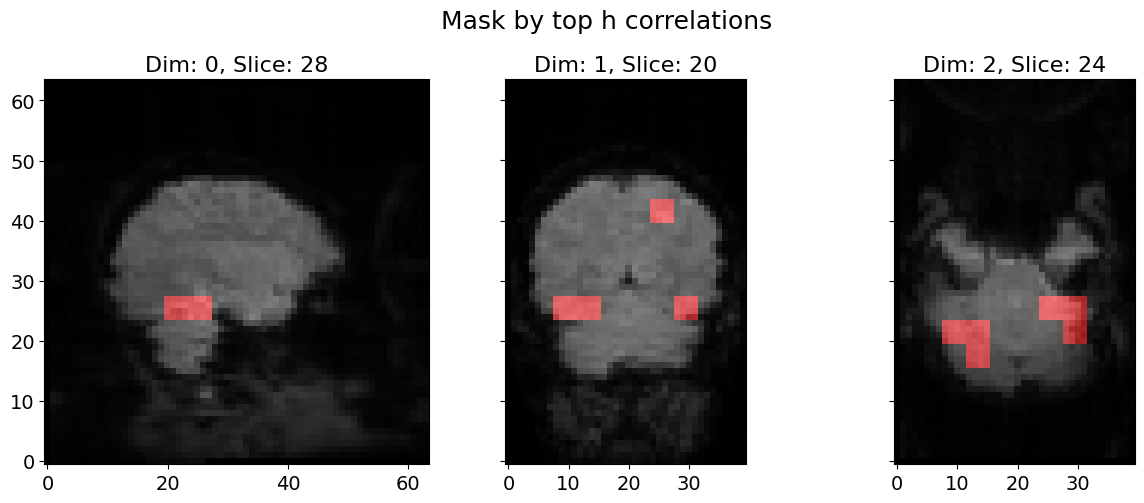

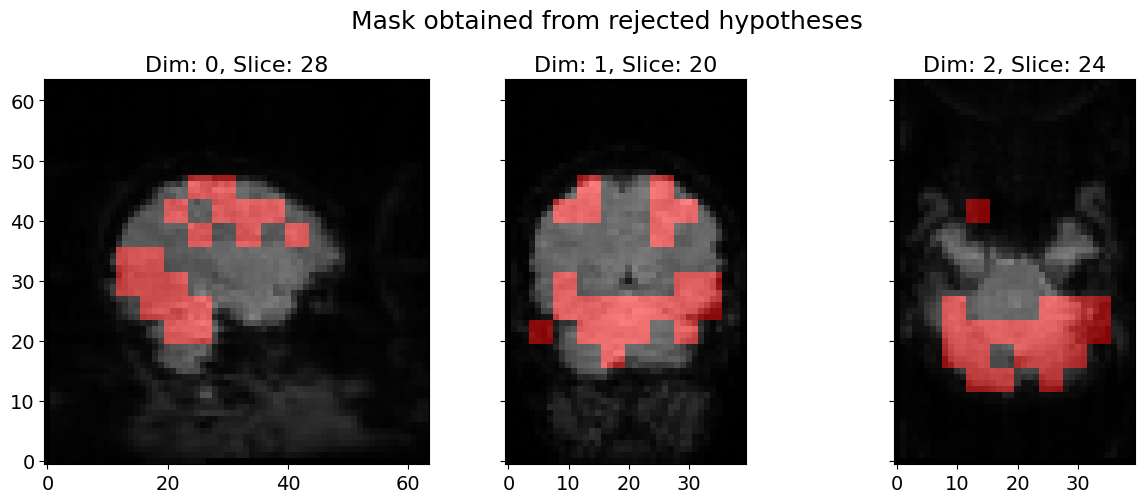

The number of areas obtained by statistical analysis: 7744


In [ ]:
fMRI_cat = np.array(X[12]).astype('float64')
s_cat = s[12].astype('int')
s_cat[s_cat!=0]=1

plot_ccw_results(X=fMRI_cat, s=s_cat, mu=2.5, k_s=4, Delta_t=0, h=10, masked_brain=False)

#### 2) Bottle

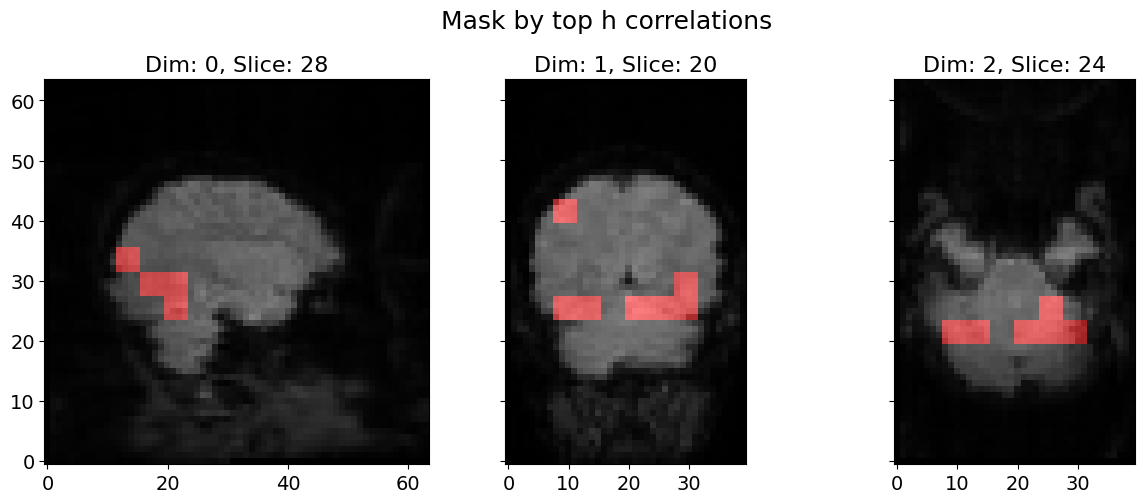

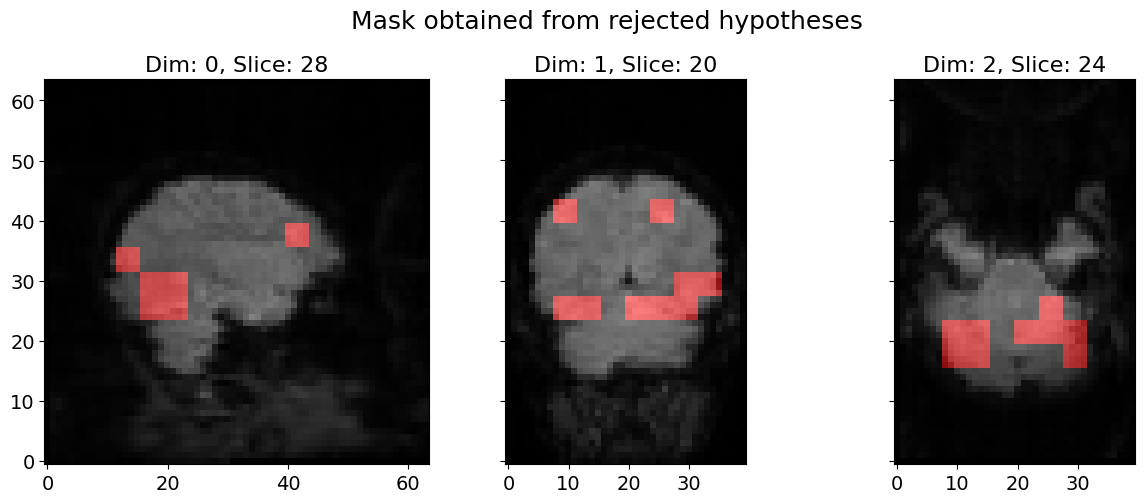

The number of areas obtained by statistical analysis: 1920


In [ ]:
fMRI_bottle = X[0].astype('float64')
s_bottle = s[0].astype('int')
s_bottle[s_bottle!=0]=1

plot_ccw_results(X=fMRI_bottle, s=s_bottle, mu=2.5, k_s=4, Delta_t=0, h=15, masked_brain=False)

#### 3) Faces

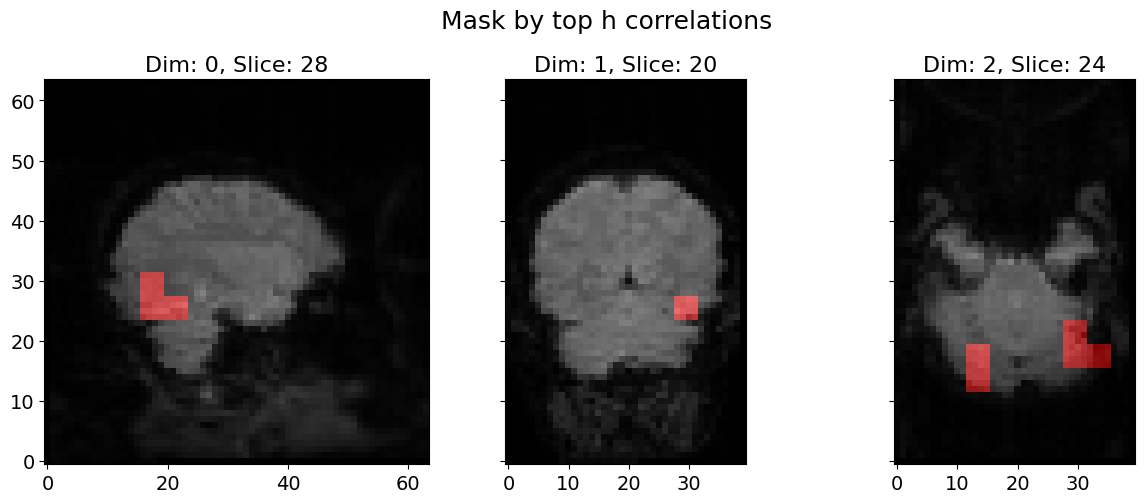

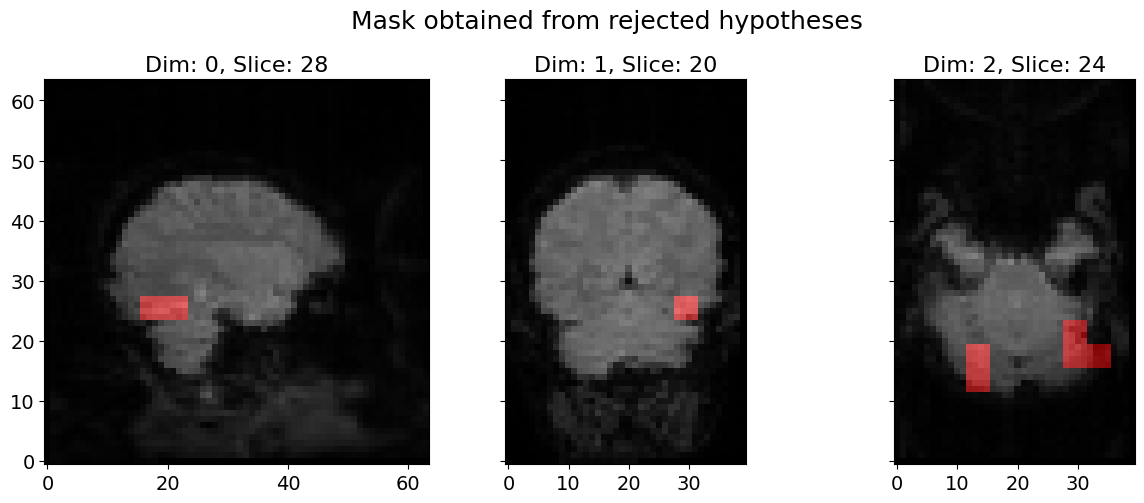

The number of areas obtained by statistical analysis: 512


In [ ]:
fMRI_face = X[40].astype('float64')
s_face = s[40].astype('int')
s_face[s_face!=0]=1

plot_ccw_results(X=fMRI_face, s=s_face, mu=2.5, k_s=4, Delta_t=0, h=10, masked_brain=False)

#### Correctness
Experiment with noise, check that the selection of areas is not random, take a random set of ones and zeros as a stimulus vector:

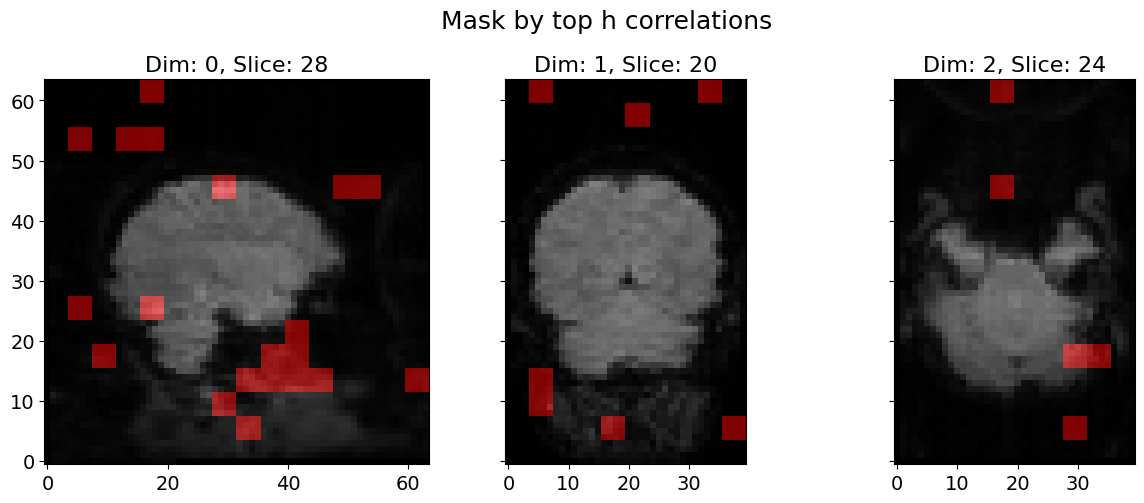

The number of areas obtained by statistical analysis: 0


In [ ]:
np.random.seed(10)
rand_s = np.random.randint(0, 2, size=fmris_transposed.shape[0])

plot_ccw_results(X=fmris_transposed, s=rand_s, mu=2.5, k_s=4, Delta_t=0, h=100, masked_brain=False)

### Classification of fMRI time series segments

In [ ]:
seed=90
np.random.seed(seed)
torch.manual_seed(seed)
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_results_for_sub(1)

Logistic Regression
Macro-average F1-Score: 0.5188
Micro-average F1-Score: 0.5500
Accuracy: 0.5500

MLP
Macro-average F1-Score: 0.6405
Micro-average F1-Score: 0.6405
Accuracy: 0.6500


In [ ]:
seed=2
np.random.seed(seed)
torch.manual_seed(seed)
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_results_for_sub(2)

Logistic Regression
Macro-average F1-Score: 0.5976
Micro-average F1-Score: 0.6500
Accuracy: 0.6500

MLP
Macro-average F1-Score: 0.6488
Micro-average F1-Score: 0.6488
Accuracy: 0.7000


In [ ]:
seed=3
np.random.seed(seed)
torch.manual_seed(seed)
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_results_for_sub(3)

Logistic Regression
Macro-average F1-Score: 0.5976
Micro-average F1-Score: 0.6500
Accuracy: 0.6500

MLP
Macro-average F1-Score: 0.6104
Micro-average F1-Score: 0.6104
Accuracy: 0.6500


In [ ]:
import numpy as np
from scipy import stats

# Результаты для каждой модели
logistic_regression_results = {
    "Macro-average F1-Score": [0.5188, 0.5976, 0.5976],
    "Micro-average F1-Score": [0.5500, 0.6500, 0.6500],
    "Accuracy": [0.5500, 0.6500, 0.6500]
}

mlp_results = {
    "Macro-average F1-Score": [0.6405, 0.6488, 0.6104],
    "Micro-average F1-Score": [0.6405, 0.6488, 0.6104],
    "Accuracy": [0.6500, 0.7000, 0.6500]
}

def calculate_confidence_interval(data, confidence_level=0.95):
    """
    Вычисляет доверительный интервал для среднего значения выборки.

    :param data: Список или массив данных.
    :param confidence_level: Уровень доверия (по умолчанию 0.95).
    :return: Доверительный интервал (нижняя граница, верхняя граница).
    """
    mean = np.mean(data)
    std_err = stats.sem(data)
    interval = stats.t.interval(confidence_level, len(data) - 1, loc=mean, scale=std_err)
    return interval

def calculate_p_value(data1, data2):
    """
    Вычисляет p-значение для независимого t-теста между двумя выборками.

    :param data1: Список или массив данных первой выборки.
    :param data2: Список или массив данных второй выборки.
    :return: p-значение.
    """
    t_stat, p_value = stats.ttest_ind(data1, data2)
    return p_value

# Вычисление доверительных интервалов и p-значений для каждой метрики
metrics = ["Macro-average F1-Score", "Micro-average F1-Score", "Accuracy"]

for metric in metrics:
    logistic_regression_ci = calculate_confidence_interval(logistic_regression_results[metric])
    mlp_ci = calculate_confidence_interval(mlp_results[metric])
    p_value = calculate_p_value(logistic_regression_results[metric], mlp_results[metric])

    print(f"Метрика: {metric}")
    print(f"Доверительный интервал для Logistic Regression: {logistic_regression_ci}")
    print(f"Доверительный интервал для MLP: {mlp_ci}")
    print(f"p-значение: {p_value}")
    print()


Метрика: Macro-average F1-Score
Доверительный интервал для Logistic Regression: (0.45831698829433054, 0.6843496783723362)
Доверительный интервал для MLP: (0.5830412504379736, 0.683425416228693)
p-значение: 0.09757011610847814

Метрика: Micro-average F1-Score
Доверительный интервал для Logistic Regression: (0.47324490900295757, 0.7600884243303758)
Доверительный интервал для MLP: (0.5830412504379736, 0.683425416228693)
p-значение: 0.6634223654312281

Метрика: Accuracy
Доверительный интервал для Logistic Regression: (0.47324490900295757, 0.7600884243303758)
Доверительный интервал для MLP: (0.5949557878348122, 0.7383775454985211)
p-значение: 0.25081535976844593



### Гипотезы для t-теста

#### Нулевая гипотеза (H0):

Нулевая гипотеза утверждает, что нет статистически значимых различий между средними значениями двух выборок. В нашем случае это означает, что средние значения метрик (Macro-average F1-Score, Micro-average F1-Score, Accuracy) для Logistic Regression и MLP равны.

Формально:
$$ H_0: \mu_{LR} = \mu_{MLP} $$
где $\mu_{LR}$ и $\mu_{MLP}$ — средние значения метрик для Logistic Regression и MLP соответственно.

#### Альтернативная гипотеза (H1):

Альтернативная гипотеза утверждает, что существует статистически значимое различие между средними значениями двух выборок. В нашем случае это означает, что средние значения метрик для Logistic Regression и MLP не равны.

Формально:
$$ H_1: \mu_{LR} \neq \mu_{MLP} $$


Можно так показать что статичстически метрики моей модели лучше метрик других моделей (а вот у моделей MLP и логрег они примерно одинаковые)

### Ablation 
1. Disable Tangent Space Mapping, use time series rectification.
2. We get a general activity mask for all time series from the training sample, then use Tangent Space Mapping.

In [ ]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_ablation_1_results_for_sub(1)

Logistic Regression
Macro-average F1-Score: 0.3149
Micro-average F1-Score: 0.3500
Accuracy: 0.3500

MLP
Macro-average F1-Score: 0.0227
Micro-average F1-Score: 0.0227
Accuracy: 0.1000


In [ ]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_ablation_1_results_for_sub(2)

Logistic Regression
Macro-average F1-Score: 0.1214
Micro-average F1-Score: 0.1500
Accuracy: 0.1500

MLP
Macro-average F1-Score: 0.0227
Micro-average F1-Score: 0.0227
Accuracy: 0.1000


In [ ]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_ablation_1_results_for_sub(3)

Logistic Regression
Macro-average F1-Score: 0.1646
Micro-average F1-Score: 0.2000
Accuracy: 0.2000

MLP
Macro-average F1-Score: 0.0227
Micro-average F1-Score: 0.0227
Accuracy: 0.1000


In [ ]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_ablation_2_results_for_sub(1)

Logistic Regression
Macro-average F1-Score: 0.2170
Micro-average F1-Score: 0.2500
Accuracy: 0.2500

MLP
Macro-average F1-Score: 0.2792
Micro-average F1-Score: 0.2792
Accuracy: 0.3000


In [ ]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_ablation_2_results_for_sub(2)

Logistic Regression
Macro-average F1-Score: 0.3756
Micro-average F1-Score: 0.4000
Accuracy: 0.4000

MLP
Macro-average F1-Score: 0.3902
Micro-average F1-Score: 0.3902
Accuracy: 0.4500


In [ ]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_ablation_2_results_for_sub(3)

Logistic Regression
Macro-average F1-Score: 0.1229
Micro-average F1-Score: 0.1500
Accuracy: 0.1500

MLP
Macro-average F1-Score: 0.0625
Micro-average F1-Score: 0.0625
Accuracy: 0.1000


### Comparison with neural network approaches

#### LSTM 

In [ ]:
train_lstm_model(1, lr=1e-4, num_epochs=3)

Epoch [1/3], Loss: 2.1971, Train Accuracy: 0.1316, Train Macro F1: 0.0529, Train Micro F1: 0.1316
Epoch [2/3], Loss: 2.1988, Train Accuracy: 0.1184, Train Macro F1: 0.0265, Train Micro F1: 0.1184
Epoch [3/3], Loss: 2.1990, Train Accuracy: 0.1184, Train Macro F1: 0.0265, Train Micro F1: 0.1184
Test Macro-average F1-Score: 0.0341
Test Micro-average F1-Score: 0.1500
Test Accuracy: 0.1500


In [ ]:
train_lstm_model(2, lr=1e-4, num_epochs=3)

Epoch [1/3], Loss: 2.2209, Train Accuracy: 0.0000, Train Macro F1: 0.0000, Train Micro F1: 0.0000
Epoch [2/3], Loss: 2.2182, Train Accuracy: 0.0000, Train Macro F1: 0.0000, Train Micro F1: 0.0000
Epoch [3/3], Loss: 2.2164, Train Accuracy: 0.0132, Train Macro F1: 0.0082, Train Micro F1: 0.0132
Test Macro-average F1-Score: 0.0222
Test Micro-average F1-Score: 0.1000
Test Accuracy: 0.1000


In [ ]:
train_lstm_model(3, lr=1e-4, num_epochs=3)

Epoch [1/3], Loss: 2.1895, Train Accuracy: 0.1316, Train Macro F1: 0.0648, Train Micro F1: 0.1316
Epoch [2/3], Loss: 2.1866, Train Accuracy: 0.1447, Train Macro F1: 0.0491, Train Micro F1: 0.1447
Epoch [3/3], Loss: 2.1850, Train Accuracy: 0.1316, Train Macro F1: 0.0291, Train Micro F1: 0.1316
Test Macro-average F1-Score: 0.0227
Test Micro-average F1-Score: 0.1000
Test Accuracy: 0.1000


In [ ]:
train_lstm_model(4, lr=1e-4, num_epochs=3)

Epoch [1/3], Loss: 2.1978, Train Accuracy: 0.1316, Train Macro F1: 0.0291, Train Micro F1: 0.1316
Epoch [2/3], Loss: 2.1882, Train Accuracy: 0.1316, Train Macro F1: 0.0291, Train Micro F1: 0.1316
Epoch [3/3], Loss: 2.1858, Train Accuracy: 0.1316, Train Macro F1: 0.0291, Train Micro F1: 0.1316
Test Macro-average F1-Score: 0.0227
Test Micro-average F1-Score: 0.1000
Test Accuracy: 0.1000


In [ ]:
train_lstm_model(5, lr=1e-4, num_epochs=3)

Epoch [1/3], Loss: 2.2116, Train Accuracy: 0.1143, Train Macro F1: 0.0389, Train Micro F1: 0.1143
Epoch [2/3], Loss: 2.2038, Train Accuracy: 0.1000, Train Macro F1: 0.0409, Train Micro F1: 0.1000
Epoch [3/3], Loss: 2.2041, Train Accuracy: 0.1429, Train Macro F1: 0.0563, Train Micro F1: 0.1429
Test Macro-average F1-Score: 0.0458
Test Micro-average F1-Score: 0.1111
Test Accuracy: 0.1111


In [ ]:
train_lstm_model(6, lr=1e-4, num_epochs=3)

Epoch [1/3], Loss: 2.2213, Train Accuracy: 0.1184, Train Macro F1: 0.0265, Train Micro F1: 0.1184
Epoch [2/3], Loss: 2.2158, Train Accuracy: 0.1184, Train Macro F1: 0.0265, Train Micro F1: 0.1184
Epoch [3/3], Loss: 2.2137, Train Accuracy: 0.1184, Train Macro F1: 0.0265, Train Micro F1: 0.1184
Test Macro-average F1-Score: 0.0326
Test Micro-average F1-Score: 0.1500
Test Accuracy: 0.1500


#### Attention based model

In [ ]:
train_attention_model(1, lr=1e-4, num_epochs=3)

Epoch [1/3], Loss: 733.1127, Train Accuracy: 0.1316, Train Macro F1: 0.0291, Train Micro F1: 0.1316
Epoch [2/3], Loss: 468.6635, Train Accuracy: 0.1316, Train Macro F1: 0.0291, Train Micro F1: 0.1316
Epoch [3/3], Loss: 322.7879, Train Accuracy: 0.1316, Train Macro F1: 0.0551, Train Micro F1: 0.1316
Test Macro-average F1-Score: 0.0868
Test Micro-average F1-Score: 0.2000
Test Accuracy: 0.2000


In [ ]:
train_attention_model(2, lr=1e-4, num_epochs=3)

Epoch [1/3], Loss: 399.6274, Train Accuracy: 0.1184, Train Macro F1: 0.0265, Train Micro F1: 0.1184
Epoch [2/3], Loss: 319.1626, Train Accuracy: 0.1184, Train Macro F1: 0.0265, Train Micro F1: 0.1184
Epoch [3/3], Loss: 214.9147, Train Accuracy: 0.1184, Train Macro F1: 0.0265, Train Micro F1: 0.1184
Test Macro-average F1-Score: 0.0227
Test Micro-average F1-Score: 0.1000
Test Accuracy: 0.1000


In [ ]:
train_attention_model(3, lr=1e-4, num_epochs=3)

Epoch [1/3], Loss: 715.1230, Train Accuracy: 0.1316, Train Macro F1: 0.0291, Train Micro F1: 0.1316
Epoch [2/3], Loss: 569.8337, Train Accuracy: 0.1316, Train Macro F1: 0.0291, Train Micro F1: 0.1316
Epoch [3/3], Loss: 424.7363, Train Accuracy: 0.1316, Train Macro F1: 0.0291, Train Micro F1: 0.1316
Test Macro-average F1-Score: 0.0607
Test Micro-average F1-Score: 0.1500
Test Accuracy: 0.1500


In [ ]:
train_attention_model(4, lr=1e-4, num_epochs=3)

Epoch [1/3], Loss: 854.1250, Train Accuracy: 0.1316, Train Macro F1: 0.0291, Train Micro F1: 0.1316
Epoch [2/3], Loss: 535.7267, Train Accuracy: 0.1184, Train Macro F1: 0.0265, Train Micro F1: 0.1184
Epoch [3/3], Loss: 367.8151, Train Accuracy: 0.0789, Train Macro F1: 0.0200, Train Micro F1: 0.0789
Test Macro-average F1-Score: 0.0326
Test Micro-average F1-Score: 0.1500
Test Accuracy: 0.1500


In [ ]:
train_attention_model(5, lr=1e-4, num_epochs=3)

Epoch [1/3], Loss: 494.7509, Train Accuracy: 0.1000, Train Macro F1: 0.0288, Train Micro F1: 0.1000
Epoch [2/3], Loss: 383.2336, Train Accuracy: 0.1286, Train Macro F1: 0.0285, Train Micro F1: 0.1286
Epoch [3/3], Loss: 156.3186, Train Accuracy: 0.0714, Train Macro F1: 0.0317, Train Micro F1: 0.0714
Test Macro-average F1-Score: 0.0250
Test Micro-average F1-Score: 0.1111
Test Accuracy: 0.1111


In [ ]:
train_attention_model(6, lr=1e-4, num_epochs=3)

Epoch [1/3], Loss: 811.4376, Train Accuracy: 0.1184, Train Macro F1: 0.0265, Train Micro F1: 0.1184
Epoch [2/3], Loss: 696.7186, Train Accuracy: 0.1316, Train Macro F1: 0.0291, Train Micro F1: 0.1316
Epoch [3/3], Loss: 717.9484, Train Accuracy: 0.1184, Train Macro F1: 0.0265, Train Micro F1: 0.1184
Test Macro-average F1-Score: 0.0326
Test Micro-average F1-Score: 0.1500
Test Accuracy: 0.1500
